In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.optimize import curve_fit
from scipy.signal import fftconvolve
import pickle
import os
%matplotlib widget

In [2]:
def fmt_err(value, error, tex=False):
    pm = r"\pm" if tex else "±"
    try:
        sig_fig = -int(np.floor(np.log10(error)))
        return f"{value:.{sig_fig}f} {pm} {error:.{sig_fig}f}"
    except:
        return f"{value} {pm} {error}"

In [3]:
class SimParams(object):
    def __init__(self, N = 100, n_steps=10000, n_analyze = 5000, n_burnin = 2000, b_top = 0.5, multiprocess = True, t_min = 1.6, t_max = 3.6, t_step = 0.1, n_trials = 10, snapshots = False):
        self.N = N
        self.n_steps = n_steps
        self.n_analyze = n_analyze
        self.n_burnin = n_burnin
        self.b_top = b_top
        self.multiprocess = multiprocess
        self.t_min = t_min
        self.t_max = t_max
        self.t_step = t_step
        self.n_trials = n_trials
        self.snapshots = snapshots
    def param_str(self):
        return f"N:{self.N} n_steps:{self.n_steps} n_analyze:{self.n_analyze} n_burnin:{self.n_burnin} b_top:{self.b_top} multiprocess:{'t' if self.multiprocess else 'f'} snapshots:{'t' if self.snapshots else 'f'} t_min:{self.t_min} t_max:{self.t_max} t_step:{self.t_step}"

def _run_raw(test_path, params: SimParams):
    #!cd .. && python ising.py N:{params.N} multiprocess:{"t" if params.multiprocess else "f"} b_top:{params.b_top} t_min:{params.t_min} t_max:{params.t_max} t_step:{params.t_step} n_steps:{params.n_steps} n_analyze:{params.n_analyze} n_burnin:{params.n_burnin}
    !cd .. && python ising.py {params.param_str()}

def copy_results(test_path, params: SimParams):
    !mv ../data/* {test_path}/result/
    if params.snapshots:
        !mv ../snapshots/* {test_path}/snapshots/

def store_metadata(test_path, params: SimParams):
    with open(f"{test_path}/metadata.txt", "w") as f:
        f.write(f"n_trials: {params.n_trials}\n")
        f.write(f"snapshots taken: {params.snapshots}\n")
        f.write(f"param string: {params.param_str()}\n")
    # Pickle the params object and store it into params.pkl
    with open(f"{test_path}/params.pkl", "wb") as f:
        pickle.dump(params, f)
        
#def rerun(test_path, snapshots=False, params: SimParams = SimParams()):
#    _run_raw(test_path, snapshots, params)
#    copy_results(test_path, snapshots)
#    store_metadata(test_path, snapshots, 1, params)
        
def run_many(test_path, params: SimParams = SimParams()):
    for i in range(params.n_trials):
        _run_raw(test_path, params)
    copy_results(test_path, params)
    store_metadata(test_path, params)

def new_test(test_path):
    !mkdir -p {test_path}/result
    !mkdir -p {test_path}/snapshots
    !mkdir -p {test_path}/plots
    

In [119]:
data_tests = "../../data_tests"
test_name = "grace/python_20_trials_100k"
test_path = f"{data_tests}/{test_name}"

if False:
    params = SimParams(N = 500, n_steps=13000, n_analyze=5000, n_burnin=5000, b_top = 5.0, multiprocess = True, t_min = 1.6, t_max = 3.6, t_step = 0.3, n_trials = 1, snapshots=True)
    #store_metadata(test_path, params)
    new_test(test_path)
    run_many(test_path, params=params)
else:
    # Unpack the params from params.pkl so we always have the right param values
    with open(f"{test_path}/params.pkl", "rb") as f:
        params = pickle.load(f)
    #params = SimParams(N = 100, n_steps=200000, n_analyze=100000, n_burnin=2000, b_top = 0.5, multiprocess = True, t_min = 1.6, t_max = 3.6, t_step = 0.1)

# Make this variable at global scope
n_trials = params.n_trials

In [120]:
# Read data from files
em = []
sc = []
ac = []

for trial in range(n_trials):
    em.append(pd.read_csv(f"{test_path}/result/{params.t_min:.2f}T{params.t_max:.2f}_EM_v{trial}.csv", skiprows=3))
    sc.append(pd.read_csv(f"{test_path}/result/{params.t_min:.2f}T{params.t_max:.2f}_SC_v{trial}.csv", skiprows=3))
    ac = sc # If we aren't taking autocorrelation every step
    # ac = pd.read_csv("data/0.00T5.00_AC_v0.csv", skiprows=3)

In [121]:
# Extract numpy arrays from dataframes

temp_size = len(em[0])
# shape: (temp)
temp = np.empty(len(em[0]))
temp[:] = em[0]["Temp"].to_numpy() # All temperatures are the same for all trials

# shape: (temp, trial)
e_mean = np.empty((temp_size, n_trials))
e_std = np.empty_like(e_mean)
m_mean = np.empty_like(e_mean)
m_std = np.empty_like(e_mean)

for trial in range(n_trials):
    e_mean[:, trial] = em[trial]["E_mean"].to_numpy()
    e_std[:, trial] = em[trial]["E_std"].to_numpy()
    m_mean[:, trial] = em[trial]["M_mean"].to_numpy()
    m_std[:, trial] = em[trial]["M_std"].to_numpy()
    
e_var = e_std ** 2
m_var = m_std ** 2

# shape: (temp, lattice_dist, trial)
sc_data = np.empty((len(temp), len(sc[0].columns) - 2, n_trials))
ac_data = np.empty((len(temp), len(sc[0].columns) - 2, n_trials))

for trial in range(n_trials):
    for lattice_dist, col_name in enumerate(sc[0].columns[1:-1]):
        sc_data[:, lattice_dist, trial] = sc[trial][col_name]
        ac_data[:, lattice_dist, trial] = ac[trial][col_name]
        
print(f"Test: {test_name}.\n{e_mean.size} runs ({temp_size} temperatures * {n_trials} trials each) in {temp[0]} <= T <= {temp[-1]}")
print(f"temp.shape = {temp.shape}, sc_data.shape = {sc_data.shape}, ac_data.shape = {ac_data.shape}")

Test: grace/python_20_trials_100k.
1800 runs (90 temperatures * 20 trials each) in 1.8 <= T <= 3.580000000000002
temp.shape = (90,), sc_data.shape = (90, 49, 20), ac_data.shape = (90, 49, 20)


In [122]:
#e_mean_error = e_std.mean(axis=1) / np.sqrt(n_trials)
#m_mean_error = m_std.mean(axis=1) / np.sqrt(n_trials)

e_mean_error = e_mean.std(axis=1) / np.sqrt(n_trials)
m_mean_error = m_mean.std(axis=1) / np.sqrt(n_trials)

sc_data *= params.N
ac_data *= params.N

In [123]:
pcw_sinh = lambda T : (T < 2.269) * ((1 - np.sinh(2 / T) ** (-4)) ** (1 / 8))

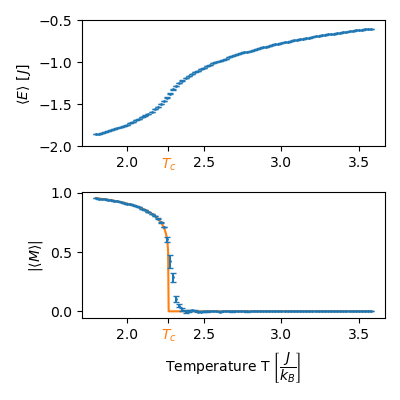

In [250]:
plt.close()
fig, ax = plt.subplots(2, figsize=(4, 4))

ax[0].errorbar(temp, e_mean.mean(axis=1), e_mean_error, fmt='.', capsize=2, markersize=2)
#ax[0].set_xlabel(r"Temperature $\left[\dfrac{k_B T}{J}\right]$")
ax[0].set_ylabel(r"$\left<E\right>$ $\left[\, J\right]$")
ax[0].set_ylim(-2, -0.5)
#ax[0].set_xlim(temp[0], temp[-1])

x = np.linspace(temp[0], temp[-1], 500)
ax[1].plot(x, np.piecewise(x, [x < 2.269, x >= 2.269], [pcw_sinh, 0]), color="tab:orange", label="Analytic solution")

#ax[0].vlines(2.269, e_mean.mean(axis=1).min(), e_mean.mean(axis=1).max(), colors='k', linestyles='dashed', alpha=0.35, label="$T_c$ (analytic)")
#ax[1].vlines(2.269, 0, 1, colors='k', linestyles='dashed', alpha=0.35, label="$T_c$ (analytic)")

ax[1].errorbar(temp, m_mean.mean(axis=1), m_mean_error, fmt='.', label="data", capsize=2, markersize=2)

for axis in ax:
    #xticks = axis.get_xticks()
    #print(xticks)
    #xticks = np.append(xticks, 2.269)
    xticks = np.arange(2.0, temp[-1] + 0.1, 0.5)
    xticks = np.append(xticks, 2.269)
    axis.set_xticks(xticks)
    axis.set_xticklabels([f"{x:.1f}" if x != 2.269 else "$T_c$" for x in xticks])
    tc_label = axis.get_xticklabels()[-1]
    tc_label.set_color("tab:orange")

ax[1].set_ylabel(r"$|\left<M\right>|$")

ax[1].set_xlabel(r"Temperature T $\left[\dfrac{J}{k_B}\right]$")
#ax[1].legend()

fig.tight_layout()
plt.savefig(f"{test_path}/plots/fig2_EMplots.png")

In [125]:
e_var_avg = e_var.mean(axis=1)
e_var_error = e_var.std(axis=1) / np.sqrt(n_trials)
m_var_avg = m_var.mean(axis=1)
m_var_error = m_var.std(axis=1) / np.sqrt(n_trials)

cv = params.N ** 2 * e_var_avg / temp ** 2
cv_error = cv * e_var_error / e_var_avg # Propagate error in cv
chi = params.N ** 2 * m_var_avg / temp
chi_error = chi * m_var_error / m_var_avg # Propagate error in chi

In [126]:
partition_radius = 0.1 # In units of T
outer_radius = 0.4
analytic_T_c = 2.269
# 2.269 is the analytic critical temperature for the 2D Ising model
partition_l = temp.searchsorted(analytic_T_c - partition_radius)
partition_r = temp.searchsorted(analytic_T_c + partition_radius)

outer_l = temp.searchsorted(analytic_T_c - outer_radius)
outer_r = temp.searchsorted(analytic_T_c + outer_radius)
print(f"Left: {temp[outer_l - 1]:.3f} <= T < {temp[partition_l - 1]:.3f}\nRight: {temp[partition_r]:.3f} <= T < {temp[outer_r]:.3f}")

t_red = (temp - analytic_T_c) / analytic_T_c
t_red_pos = t_red > 0
mlogt = -np.log(t_red[t_red_pos])

Left: 1.860 <= T < 2.160
Right: 2.380 <= T < 2.680


In [127]:
# Underconstrained fit to cv to determine T_c

log = lambda T, a, b, T_c: a + b * np.log(np.abs((T - T_c) / T_c))

cv_p_pos, cv_covm_pos = curve_fit(log, temp[partition_r:outer_r], cv[partition_r:outer_r], p0 = (0, -1, analytic_T_c), sigma=cv[partition_r:outer_r])
cv_Tc_r = cv_p_pos[2]
cv_p_neg, cv_covm_neg = curve_fit(log, temp[outer_l:partition_l], cv[outer_l:partition_l], p0 = (0, -1, analytic_T_c), sigma=cv_error[outer_l:partition_l])
cv_Tc_l = cv_p_neg[2]

cv_var_pos = np.sqrt(np.diag(cv_covm_pos))
cv_var_neg = np.sqrt(np.diag(cv_covm_neg))
cv_corr_pos = cv_covm_pos / np.outer(cv_var_pos, cv_var_pos)
cv_corr_neg = cv_covm_neg / np.outer(cv_var_neg, cv_var_neg)

print(f"Left: T_c = {cv_p_neg[2]:.3f} ± {cv_var_neg[2]:.3f}, amplitude = {cv_p_neg[1]:.3f} ± {cv_var_neg[1]:.3f}, offset = {cv_p_neg[0]:.3f} ± {cv_var_neg[0]:.3f}")
print(f"T_c & amplitude: {cv_corr_neg[1, 2]:.3f}; T_c & offset: {cv_corr_neg[0, 2]:.3f}; amplitude & offset: {cv_corr_neg[0, 1]:.3f}")
print(f"Right: T_c = {cv_p_pos[2]:.3f} ± {cv_var_pos[2]:.3f}, amplitude = {cv_p_pos[1]:.3f} ± {cv_var_pos[1]:.3f}, offset = {cv_p_pos[0]:.3f} ± {cv_var_pos[0]:.3f}")
print(f"T_c & amplitude: {cv_corr_pos[1, 2]:.3f}; T_c & offset: {cv_corr_pos[0, 2]:.3f}; amplitude & offset: {cv_corr_pos[0, 1]:.3f}")

Left: T_c = 2.272 ± 0.008, amplitude = -0.556 ± 0.019, offset = -0.444 ± 0.025
T_c & amplitude: -0.980; T_c & offset: -0.952; amplitude & offset: 0.994
Right: T_c = 2.278 ± 0.014, amplitude = -0.474 ± 0.033, offset = -0.200 ± 0.042
T_c & amplitude: 0.981; T_c & offset: 0.943; amplitude & offset: 0.989


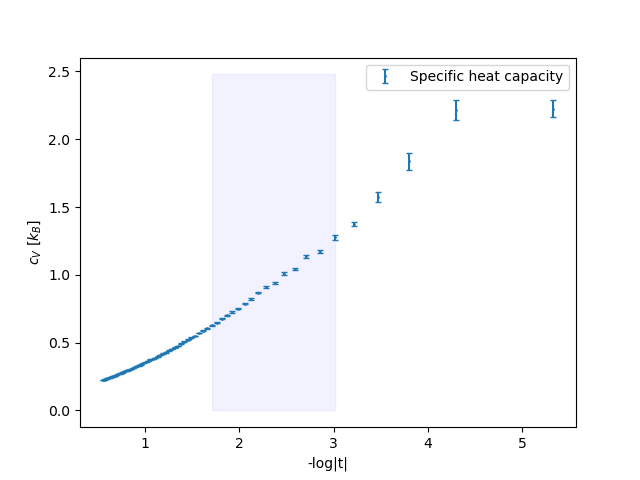

In [129]:
plt.close()
fig, ax = plt.subplots()

ax.errorbar(mlogt, cv[t_red_pos], yerr=cv_error[t_red_pos], fmt=".", label="Specific heat capacity", capsize=2, markersize=2)
ax.fill_betweenx([0, cv.max() * 1.1], -np.log(t_red[partition_r]), -np.log(t_red[outer_r]), color="blue", alpha=0.05)

ax.set_xlabel(r"-log|t|")
ax.set_ylabel(r"$c_V$ $\left[k_B\right]$")
ax.legend()

In [130]:
# Underconstrained fit to chi to determine T_c

chi_powerlaw = lambda T, a, gamma, T_c: a * np.abs((T - T_c) / T_c)**(-gamma)

chi_p, chi_covm = curve_fit(chi_powerlaw, temp[partition_r:outer_r], chi[partition_r:outer_r], p0 = (1, 1, analytic_T_c), sigma=chi_error[partition_r:outer_r])
chi_Tc = chi_p[2]
#chi_p_neg, chi_covm_neg = curve_fit(chi_powerlaw, temp[:partition_l], chi[:partition_l], p0 = (1, 1, analytic_T_c), sigma=chi_error[:partition_l])
chi_variance = np.sqrt(np.diag(chi_covm))
chi_corrm = chi_covm / np.outer(chi_variance, chi_variance)

print(f"T_c = {chi_p[2]:.2f} ± {chi_variance[2]:.2f} gamma = {chi_p[1]:.2f} ± {chi_variance[1]:.2f}; amplitude = {chi_p[0]:.2f} ± {chi_variance[0]:.2f}")
print(f"T_c & gamma = {chi_corrm[1, 2]:.2f}; T_c & amplitude = {chi_corrm[0, 2]:.2f}; gamma & amplitude = {chi_corrm[0, 1]:.2f}")

T_c = 2.27 ± 0.02 gamma = 1.66 ± 0.14; amplitude = 0.51 ± 0.08
T_c & gamma = -0.98; T_c & amplitude = 0.95; gamma & amplitude = -0.99


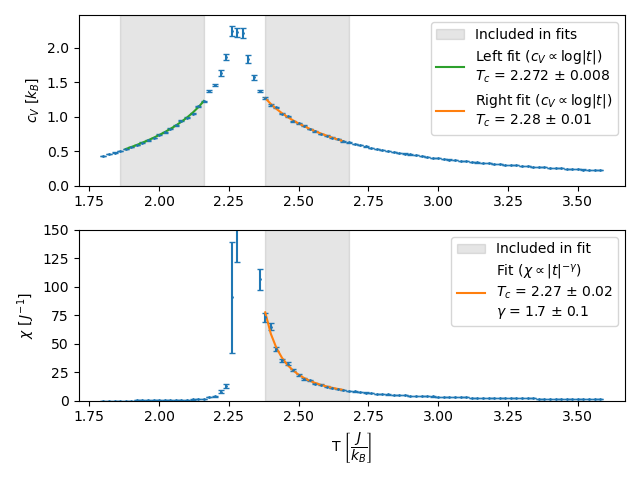

In [259]:
# Plot cv with both fits

plt.close()
fig, ax = plt.subplots(2)

ax[0].set_ylim(0, cv.max() * 1.1)

#ax.vlines([temp[partition_l - 1], temp[partition_r]], 0, cv.max() * 1.1, linestyles="solid", color="black", alpha=0.7, label="exclusion radius")
#ax.fill_betweenx([0, cv.max() * 1.1], temp[partition_l - 1], temp[partition_r], color="black", alpha=0.1, label="exclusion radius")
ax[0].fill_betweenx([0, cv.max() * 1.1], temp[outer_l - 1], temp[partition_l - 1], color="black", alpha=0.1, label="Included in fits")
ax[0].fill_betweenx([0, cv.max() * 1.1], temp[partition_r], temp[outer_r], color="black", alpha=0.1)
#ax.vlines(analytic_T_c, 0, cv.max() * 1.1, linestyles="solid", color="red", label="$T_c$ (analytic)")
#ax.vlines(cv_p_neg[2], 0, cv.max() * 1.1, linestyles="dashed", color="tab:green", label=f"$T_c$ (left fit) = {cv_p_neg[2]:.3f}")
#ax.vlines(cv_p_pos[2], 0, cv.max() * 1.1, linestyles="dashed", color="tab:orange", label=f"$T_c$ (right fit) = {cv_p_pos[2]:.3f}")

ax[0].errorbar(temp, cv, yerr=cv_error, fmt=".", capsize=2, markersize=2)
ax[0].plot(temp[outer_l:partition_l], log(temp[outer_l:partition_l], *cv_p_neg), color="tab:green", label=f"Left fit ($c_V \propto \log |t|$)\n$T_c$ = {fmt_err(cv_p_neg[2], cv_var_neg[2])}")
ax[0].plot(temp[partition_r:outer_r], log(temp[partition_r:outer_r], *cv_p_pos), color="tab:orange", label=f"Right fit ($c_V \propto \log |t|$)\n$T_c$ = {fmt_err(cv_p_pos[2], cv_var_pos[2])}")

ax[0].legend()
#ax[0].set_xlabel(r"T $\left[\dfrac{J}{k_B}\right]$")
ax[0].set_ylabel(r"$c_V$ $\left[k_B\right]$")

ax[1].set_ylim(0, chi.max() * 1.1)

#ax.vlines([temp[partition_l - 1], temp[partition_r]], 0, chi.max() * 1.1, linestyles="solid", color="black", alpha=0.7, label="exclusion radius")
ax[1].fill_betweenx([0, chi.max() * 1.1], temp[partition_r], temp[outer_r], color="black", alpha=0.1, label="Included in fit")
#ax.vlines(analytic_T_c, 0, chi.max() * 1.1, linestyles="solid", color="tab:red", label=f"$T_c$ (analytic) = {analytic_T_c:.3f}")
#ax.vlines(chi_p[2], 0, chi.max() * 1.1, linestyles="dashed", color="tab:green", label=f"$T_c$ (fit) = {chi_p[2]:.3f}")

ax[1].errorbar(temp, chi, yerr=chi_error, fmt=".", color="tab:blue", capsize=2, markersize=2)
ax[1].plot(temp[partition_r:outer_r], chi_powerlaw(temp[partition_r:outer_r], *chi_p), color="tab:orange", label=(r"Fit ($\chi \propto |t|^{-\gamma}$)" + f"\n$T_c$ = {fmt_err(chi_p[2], chi_variance[2])}\n$\gamma$ = {fmt_err(chi_p[1], chi_variance[1])}"))

ax[1].set_ylim(0, 150)

ax[1].legend()
ax[1].set_xlabel(r"T $\left[\dfrac{J}{k_B}\right]$")
ax[1].set_ylabel(r"$\chi$ $\left[ \,J^{-1} \right]$")

fig.tight_layout()

plt.savefig(f"{test_path}/plots/fig3.png")

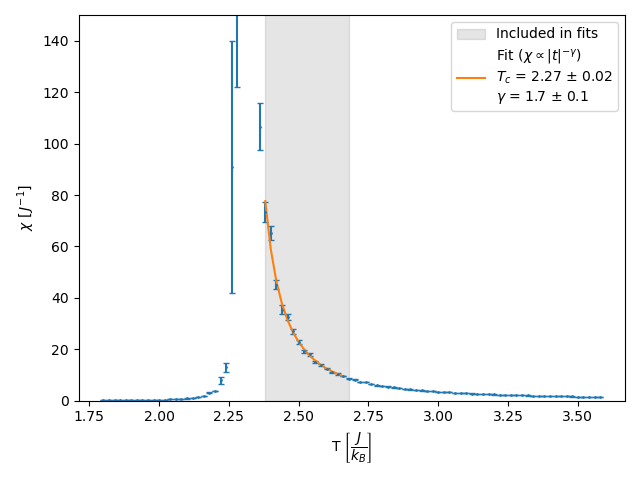

In [253]:
# Plot chi with fit

plt.close()
fig, ax = plt.subplots()

ax.set_ylim(0, chi.max() * 1.1)

#ax.vlines([temp[partition_l - 1], temp[partition_r]], 0, chi.max() * 1.1, linestyles="solid", color="black", alpha=0.7, label="exclusion radius")
ax.fill_betweenx([0, chi.max() * 1.1], temp[partition_r], temp[outer_r], color="black", alpha=0.1, label="Included in fits")
#ax.vlines(analytic_T_c, 0, chi.max() * 1.1, linestyles="solid", color="tab:red", label=f"$T_c$ (analytic) = {analytic_T_c:.3f}")
#ax.vlines(chi_p[2], 0, chi.max() * 1.1, linestyles="dashed", color="tab:green", label=f"$T_c$ (fit) = {chi_p[2]:.3f}")

ax.errorbar(temp, chi, yerr=chi_error, fmt=".", color="tab:blue", capsize=2, markersize=2)
ax.plot(temp[partition_r:outer_r], chi_powerlaw(temp[partition_r:outer_r], *chi_p), color="tab:orange", label=(r"Fit ($\chi \propto |t|^{-\gamma}$)" + f"\n$T_c$ = {fmt_err(chi_p[2], chi_variance[2])}\n$\gamma$ = {fmt_err(chi_p[1], chi_variance[1])}"))

ax.set_ylim(0, 150)

ax.legend()
ax.set_xlabel(r"T $\left[\dfrac{J}{k_B}\right]$")
ax.set_ylabel(r"$\chi$ $\left[ \,J^{-1} \right]$")
fig.tight_layout()

plt.savefig(f"{test_path}/plots/fig3_chi.png")

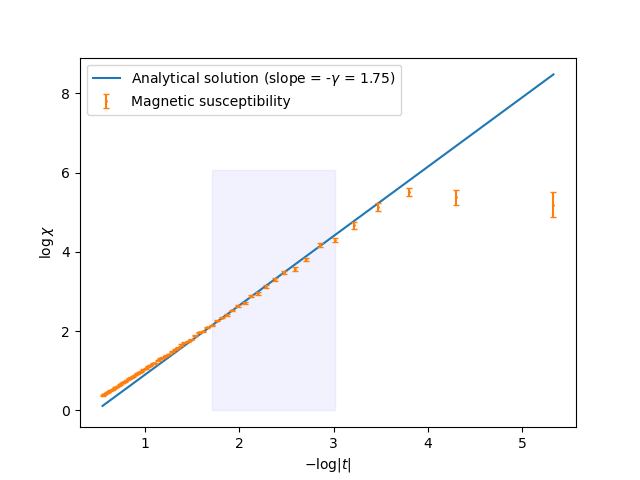

In [140]:
plt.close()
fig, ax = plt.subplots()

logchi = np.log(chi[t_red_pos])
logchi_error = chi_error[t_red_pos] / chi[t_red_pos]

#ax.plot(logt, logchi[0] - 1.75 * (logt - logt[0]))
ax.plot(mlogt, np.log(chi[outer_r]) + 1.75 * (mlogt + np.log(t_red[outer_r])), label="Analytical solution (slope = -$\gamma$ = 1.75)")

ax.errorbar(mlogt, logchi, yerr=logchi_error, fmt=".", label="Magnetic susceptibility", capsize=2, markersize=2)
ax.fill_betweenx([0, logchi.max() * 1.1], -np.log(t_red[partition_r]), -np.log(t_red[outer_r]), color="blue", alpha=0.05)

ax.set_xlabel(r"$-\log |t|$")
ax.set_ylabel(r"$\log \chi$")
ax.legend()

In [82]:
# Get autocorrelation functions from sc_data
# sc_data.shape = (100, 49, 31)
sc_data.shape

(100, 49, 98)

In [260]:
decay_fit = lambda x, a, b, c: a * np.exp(-b * x) + c
#decay_fit = lambda x, a, b: a * np.exp(-b * x)

autocor_x = np.arange(sc_data.shape[1])

xi = np.empty_like(temp)
xi_error = np.empty_like(xi)
autocor_amplitude = np.empty_like(xi)
shift = np.zeros_like(xi)

for i in range(len(temp)):
    autocor_y = sc_data[i, :, :].mean(axis=1)
    autocor_y_error = sc_data[i, :, :].std(axis=1) / np.sqrt(n_trials)
    max_x = np.argwhere(autocor_y < 0)[0, 0]
    
    # ZERO THING
    #if max_x <= 2:
    #    xi[i] = np.nan
    #    xi_error[i] = np.nan
    #    continue
    #sc_p, sc_covm = curve_fit(decay_fit, autocor_x[:max_x], autocor_y[:max_x], p0 = (autocor_y[0], 0.1), sigma=autocor_y_error[:max_x])
    # END ZERO THING
    #print(max_x)
    #sc_p, sc_covm = curve_fit(decay_fit, autocor_x, sc_data[i, trial], p0 = (1, 0.1))
    
    # Y INTERCEPT THING
    sc_p, sc_covm = curve_fit(decay_fit, autocor_x, autocor_y, p0 = (autocor_y[0], 0.1, -0.01), sigma=autocor_y_error)
    shift[i] = sc_p[2]
    
    xi[i] = 1 / sc_p[1]
    autocor_amplitude[i] = sc_p[0]
    xi_error[i] = np.sqrt(sc_covm[1, 1]) / sc_p[1] ** 2
    if np.abs(xi[i]) > params.N / 2:
        xi[i] = np.nan
        xi_error[i] = np.nan

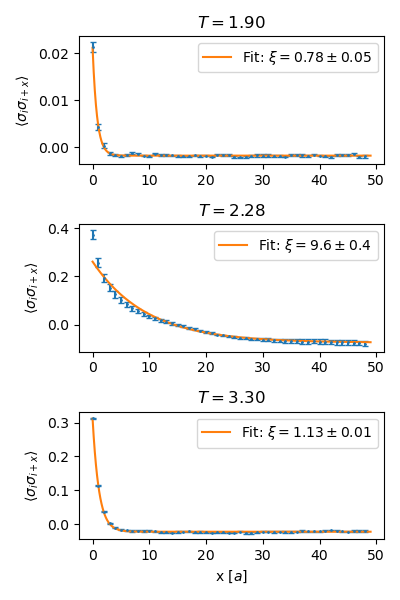

In [266]:
plt.close()
fig, ax = plt.subplots(3, figsize=(4, 6))

temp_indices = [np.searchsorted(temp, T) for T in [1.9, 2.269, 3.3]]

ax[2].set_xlabel("x [$a$]")
for axis, idx in enumerate(temp_indices):
    autocor_x = np.arange(sc_data.shape[1])
    autocor_x_fine = np.linspace(0, sc_data.shape[1], 500)
    ax[axis].set_ylabel(r"$\langle \sigma_i \sigma_{i + x} \rangle$")
    ax[axis].errorbar(autocor_x, sc_data[idx].mean(axis=1), sc_data[idx].std(axis=1) / np.sqrt(n_trials), fmt=".", capsize=2, markersize=2)
    ax[axis].set_title(f"$T = {temp[idx]:.2f}$")
    y = decay_fit(autocor_x_fine, autocor_amplitude[idx], 1 / xi[idx], shift[idx])
    #y = decay_fit(autocor_x_fine, autocor_amplitude[idx], 1 / xi[idx])
    ax[axis].plot(autocor_x_fine, y, label=f"Fit: $\\xi = {fmt_err(xi[idx], xi_error[idx], tex=True)}$")
    ax[axis].legend()
    
fig.tight_layout()

plt.savefig(f"{test_path}/plots/fig4_autocors.png")

In [267]:
xi_powerlaw = lambda T, a, nu, T_c: a * np.abs((T - T_c) / T_c)**(-nu)

xi_p, xi_covm = curve_fit(xi_powerlaw, temp[partition_r:outer_r], xi[partition_r:outer_r], p0 = (1, 1, analytic_T_c), sigma=xi_error[partition_r:outer_r])

xi_Tc = xi_p[2]

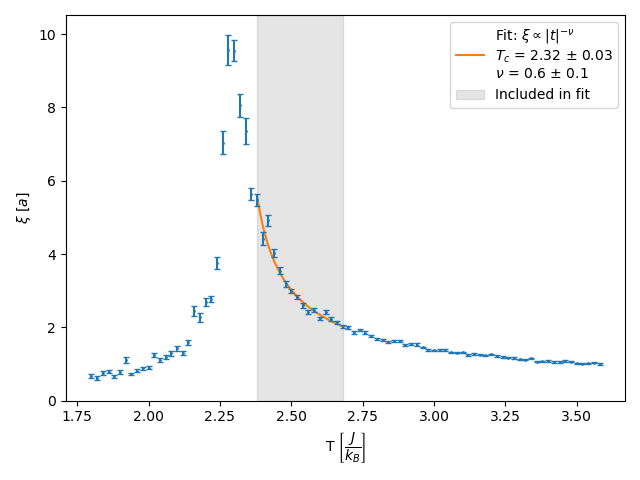

In [268]:
plt.close()
fig, ax = plt.subplots()

x = np.linspace(temp[partition_r], temp[outer_r], 500)
ax.plot(x, xi_powerlaw(x, *xi_p), color="tab:orange", label=r"Fit: $\xi \propto |t|^{-\nu}$" + f"\n$T_c$ = {fmt_err(xi_p[2], np.sqrt(xi_covm[2, 2]))}\n$\\nu$ = {fmt_err(xi_p[1], np.sqrt(xi_covm[1, 1]))}")
ax.fill_betweenx([0, xi.max() * 1.1], temp[partition_r], temp[outer_r], color="black", alpha=0.1, label="Included in fit")

ax.errorbar(temp, xi, xi_error, fmt=".", capsize=2, color="tab:blue", markersize=2)
ax.set_xlabel(r"T $\left[\dfrac{J}{k_B}\right]$")
ax.set_ylabel(r"$\xi$ $\left[a\right]$")

ax.legend()

ax.set_ylim(0, xi.max() * 1.1)

fig.tight_layout()

plt.savefig(f"{test_path}/plots/fig4_xi.png")

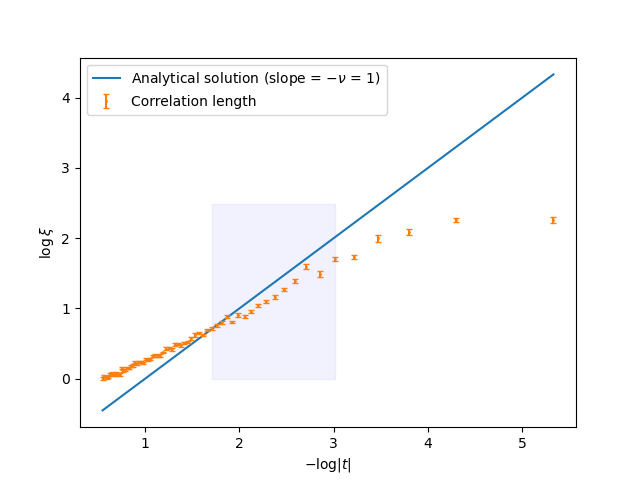

In [269]:
plt.close()
fig, ax = plt.subplots()

t_red = (temp - analytic_T_c) / analytic_T_c
t_red_pos = t_red > 0
logt = -np.log(t_red[t_red_pos])
logxi = np.log(xi[t_red_pos])
logxi_error = xi_error[t_red_pos] / xi[t_red_pos]

ax.plot(logt, np.log(xi[outer_r]) + 1 * (logt + np.log(t_red[outer_r])), label="Analytical solution (slope = $-\\nu$ = 1)")
ax.errorbar(logt, logxi, yerr=logxi_error, fmt=".", label="Correlation length", capsize=2, markersize=2)
ax.fill_betweenx([0, logxi.max() * 1.1], -np.log(t_red[partition_r]), -np.log(t_red[outer_r]), color="blue", alpha=0.05)

ax.set_xlabel(r"$-\log |t|$")
ax.set_ylabel(r"$\log \xi$")
ax.legend()

cV = -0.220 + 0.492 * log(t)
Reduced chi-squared = 1.553 for DoF = 13
gamma = 1.674 ± 0.024
beta = 0.097 ± 0.001
nu = 0.760 ± 0.041


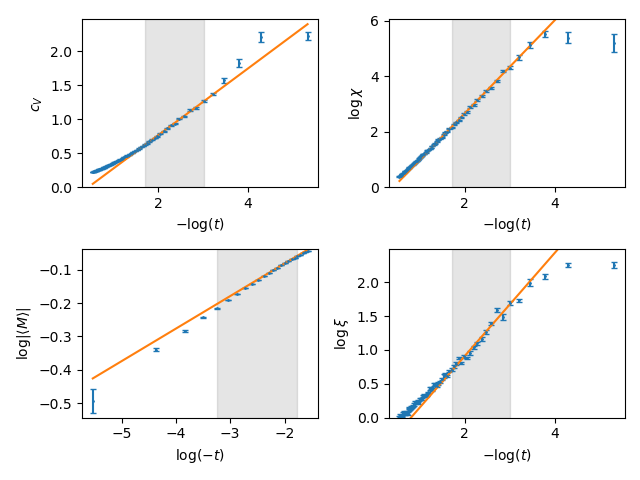

In [320]:
plt.close()
fig, ax = plt.subplots(2, 2)

ax[0, 0].errorbar(mlogt, cv[t_red_pos], yerr=cv_error[t_red_pos], fmt=".", capsize=2, markersize=2)
ax[0, 0].set_xlabel(r"$-\log(t)$")
ax[0, 0].set_ylabel(r"$c_V$")
ax[0, 0].fill_betweenx([0, cv.max() * 1.1], -np.log(t_red[partition_r]), -np.log(t_red[outer_r]), color="black", alpha=0.1)
popt, pcov = curve_fit(lambda x, a, b : a * x + b, -np.log(t_red[partition_r:outer_r]), cv[partition_r:outer_r], p0 = (1, 0), sigma=cv_error[partition_r:outer_r])
print(f"cV = {popt[1]:.3f} + {popt[0]:.3f} * log(t)")
chisq = np.sum(((-np.log(t_red[partition_r:outer_r]) * popt[0] + popt[1]) - cv[partition_r:outer_r]) ** 2 / cv_error[partition_r:outer_r] ** 2) / (len(cv[partition_r:outer_r]) - 2)
print(f"Reduced chi-squared = {chisq:.3f} for DoF = {len(cv[partition_r:outer_r]) - 2}")
#chisq = np.sum((cv[t_red_pos] - (popt[1] + popt[0] * mlogt)) ** 2 / (cv_error[t_red_pos] ** 2)) / 
ax[0, 0].plot(mlogt, popt[1] + popt[0] * mlogt)
ax[0, 0].set_ylim(0, cv.max() * 1.1)

ax[0, 1].errorbar(mlogt, logchi, yerr=logchi_error, fmt=".", capsize=2, markersize=2)
ax[0, 1].set_xlabel(r"$-\log(t)$")
ax[0, 1].set_ylabel(r"$\log \chi$")
#ax[0, 1].plot(mlogt, logchi[-1] + 1.75 * (mlogt - mlogt[-1]), label="Analytical solution (slope = -$\gamma$ = 1.75)")
ax[0, 1].fill_betweenx([0, logchi.max() * 1.1], -np.log(t_red[partition_r]), -np.log(t_red[outer_r]), color="black", alpha=0.1)
logchi_fitrange = np.log(chi[partition_r:outer_r])
logchi_error_fitrange = chi_error[partition_r:outer_r] / chi[partition_r:outer_r]
popt, pcov = curve_fit(lambda x, a, b : a * x + b, -np.log(t_red[partition_r:outer_r]), logchi_fitrange, p0 = (1.75, -0.8), sigma=logchi_error_fitrange)
print(f"gamma = {popt[0]:.3f} ± {np.sqrt(pcov[0, 0]):.3f}")
ax[0, 1].plot(mlogt, popt[1] + popt[0] * mlogt)
ax[0, 1].set_ylim(0, logchi.max() * 1.1)

t_red_neg = t_red < 0
t_neg = -t_red[t_red_neg]
logt_neg = np.log(t_neg)
overall_m = np.abs(m_mean.mean(axis=1))
logm = np.log(overall_m)
#ax[1, 0].errorbar(t_red[t_red_neg], m_mean.mean(axis=1)[t_red_neg], yerr=cv_error[t_red_neg], fmt=".", capsize=2, markersize=2)
ax[1, 0].errorbar(logt_neg, logm[t_red_neg], yerr=m_mean_error[t_red_neg] / overall_m[t_red_neg], fmt=".", capsize=2, markersize=2)
ax[1, 0].set_xlabel(r"$\log(-t)$")
ax[1, 0].set_ylabel(r"$\log|\left<M\right>|$")
#ax[1, 0].plot(mlogt_neg, logm[0] - 0.125 * (mlogt_neg -mlogt_neg[0]), label="Analytical solution (slope = 0.125)")
ax[1, 0].fill_betweenx([logm[t_red_neg].min() * 1.1, logm[t_red_neg].max() * 0.9], np.log(-t_red[partition_l]), np.log(-t_red[outer_l]), color="black", alpha=0.1)
popt, pcov = curve_fit(lambda x, a, b : a * x + b, np.log(-t_red[outer_l:partition_l]), logm[outer_l:partition_l], p0 = (1.75, -0.8), sigma=m_mean_error[outer_l:partition_l] / overall_m[outer_l:partition_l])
print(f"beta = {popt[0]:.3f} ± {np.sqrt(pcov[0, 0]):.3f}")
ax[1, 0].plot(logt_neg, popt[1] + popt[0] * logt_neg)
ax[1, 0].set_ylim(logm[t_red_neg].min() * 1.1, logm[t_red_neg].max() * 0.9)

ax[1, 1].errorbar(mlogt, logxi, yerr=logxi_error, fmt=".", capsize=2, markersize=2)
ax[1, 1].set_xlabel(r"$-\log(t)$")
ax[1, 1].set_ylabel(r"$\log \xi$")
#ax[1, 1].plot(mlogt, logxi[-1] + 1 * (mlogt - mlogt[-1]), label="Analytical solution (slope = $-\\nu$ = 1)")
ax[1, 1].fill_betweenx([0, logxi.max() * 1.1], -np.log(t_red[partition_r]), -np.log(t_red[outer_r]), color="black", alpha=0.1)
logxi_fitrange = np.log(xi[partition_r:outer_r])
logxi_error_fitrange = xi_error[partition_r:outer_r] / xi[partition_r:outer_r]
popt, pcov = curve_fit(lambda x, a, b : a * x + b, -np.log(t_red[partition_r:outer_r]), logxi_fitrange, p0 = (1.75, -0.8), sigma=logxi_error_fitrange)
print(f"nu = {popt[0]:.3f} ± {np.sqrt(pcov[0, 0]):.3f}")
ax[1, 1].plot(mlogt, popt[1] + popt[0] * mlogt)
ax[1, 1].set_ylim(0, logxi.max() * 1.1)

fig.tight_layout()
plt.savefig(f"{test_path}/plots/lastfig.png")

In [92]:
# Fit critical exponents
t_norm = lambda T_c : (temp - T_c) / T_c

USE_PRECALCULATED_TC = False
if USE_PRECALCULATED_TC:
    t_norm_cv = t_norm((cv_Tc_r + cv_Tc_l) / 2)
    t_norm_chi = t_norm(chi_Tc)
    t_norm_M = t_norm(2.269)
    t_norm_xi = t_norm(xi_Tc)
else:
    t_norm_cv = t_norm(2.269)
    t_norm_chi = t_norm(2.269)
    t_norm_M = t_norm(2.269)
    t_norm_xi = t_norm(2.269)

fit_cv = lambda t, a, c: a * np.log(np.abs(t)) + c
fit_chi = lambda t, a, gamma: a * np.abs(t)**(-gamma)
fit_M = lambda t, a, beta: a * np.abs(t)**beta
fit_xi = lambda t, a, nu: a * np.abs(t)**(-nu)

# cv
crit_cv_r, crit_cv_covm_r = curve_fit(fit_cv, t_norm_cv[partition_r:outer_r], cv[partition_r:outer_r], p0 = (-1, 0), sigma=cv_error[partition_r:outer_r])
crit_cv_l, crit_cv_covm_l = curve_fit(fit_cv, t_norm_cv[outer_l:partition_l], cv[outer_l:partition_l], p0 = (-1, 0), sigma=cv_error[outer_l:partition_l])

# chi
crit_chi, crit_chi_covm = curve_fit(fit_chi, t_norm_chi[partition_r:outer_r], chi[partition_r:outer_r], p0 = (1, 1), sigma=chi_error[partition_r:outer_r])

# M
crit_M, crit_M_covm = curve_fit(fit_M, t_norm_M[outer_l:partition_l], m_mean.mean(axis=1)[outer_l:partition_l], p0 = (1, 1), sigma=m_mean_error[outer_l:partition_l])

# xi
crit_xi, crit_xi_covm = curve_fit(fit_xi, t_norm_xi[partition_r:outer_r], xi[partition_r:outer_r], p0 = (1, 1), sigma=xi_error[partition_r:outer_r])



gamma = 1.42 ± 0.01, beta = 0.103 ± 0.002, nu = 0.50 ± 0.01


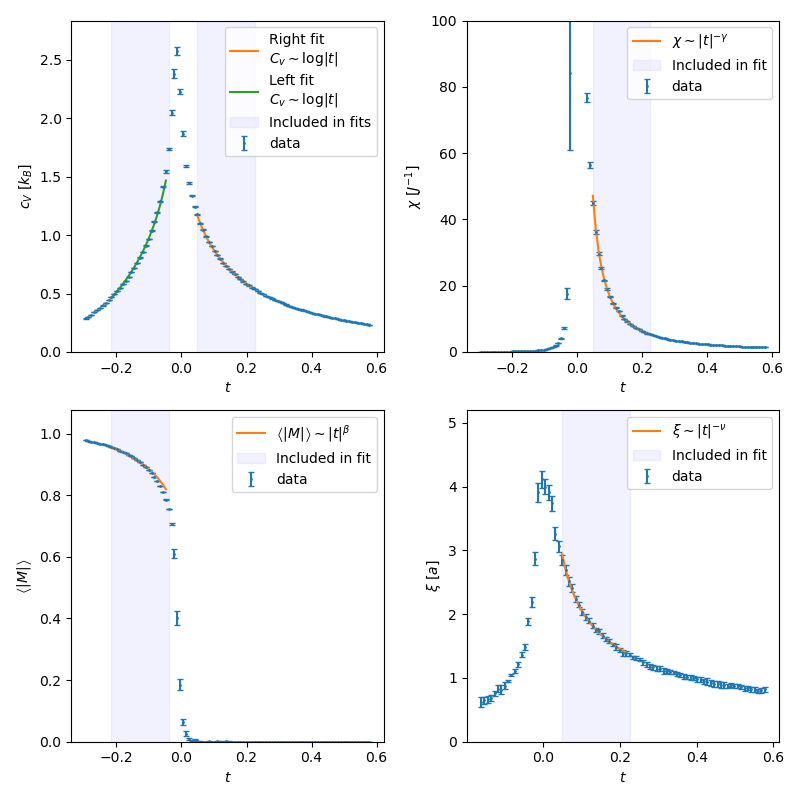

In [93]:
plt.close()
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

# cv
ax[0, 0].set_ylabel(r"$c_V$ $\left[k_B\right]$")
ax[0, 0].set_xlabel(r"$t$")

ax[0, 0].errorbar(t_norm_cv, cv, yerr=cv_error, fmt=".", label="data", capsize=2, markersize=2)
ax[0, 0].plot(t_norm_cv[partition_r:outer_r], fit_cv(t_norm_cv[partition_r:outer_r], *crit_cv_r), label="Right fit\n$C_v \sim \log |t|$")
ax[0, 0].plot(t_norm_cv[outer_l:partition_l], fit_cv(t_norm_cv[outer_l:partition_l], *crit_cv_l), label="Left fit\n$C_v \sim \log |t|$")
ax[0, 0].fill_betweenx([0, cv.max() * 1.1], t_norm_cv[outer_l], t_norm_cv[partition_l], color="blue", alpha=0.05, label="Included in fits")
ax[0, 0].fill_betweenx([0, cv.max() * 1.1], t_norm_cv[partition_r], t_norm_cv[outer_r], color="blue", alpha=0.05)
ax[0, 0].set_ylim(0, cv.max() * 1.1)
ax[0, 0].legend()

# chi
ax[0, 1].set_ylabel(r"$\chi$ $\left[J^{-1}\right]$")
ax[0, 1].set_xlabel(r"$t$")
ax[0, 1].errorbar(t_norm_chi, chi, yerr=chi_error, fmt=".", label="data", capsize=2, markersize=2)
ax[0, 1].plot(t_norm_chi[partition_r:outer_r], fit_chi(t_norm_chi[partition_r:outer_r], *crit_chi), label=r"$\chi \sim |t|^{-\gamma}$")
ax[0, 1].fill_betweenx([0, 100], t_norm_chi[partition_r], t_norm_chi[outer_r], color="blue", alpha=0.05, label="Included in fit")
ax[0, 1].set_ylim(0, 100)
ax[0, 1].legend()

# M
ax[1, 0].set_ylabel(r"$\left<|M|\right>$")
ax[1, 0].set_xlabel(r"$t$")
ax[1, 0].errorbar(t_norm_M, m_mean.mean(axis=1), m_mean_error, fmt=".", label="data", capsize=2, markersize=2)
ax[1, 0].plot(t_norm_M[outer_l:partition_l], fit_M(t_norm_M[outer_l:partition_l], *crit_M), label=r"$\left<|M|\right> \sim |t|^\beta$")
ax[1, 0].fill_betweenx([0, m_mean.mean(axis=1).max() * 1.1], t_norm_M[outer_l], t_norm_M[partition_l], color="blue", alpha=0.05, label="Included in fit")
ax[1, 0].set_ylim(0, m_mean.mean(axis=1).max() * 1.1)
ax[1, 0].legend()

# xi
ax[1, 1].set_ylabel(r"$\xi$ $\left[ a \right]$")
ax[1, 1].set_xlabel(r"$t$")
ax[1, 1].errorbar(t_norm_xi, xi, yerr=xi_error, fmt=".", label="data", capsize=2, markersize=2)
ax[1, 1].plot(t_norm_xi[partition_r:outer_r], fit_xi(t_norm_xi[partition_r:outer_r], *crit_xi), label=r"$\xi \sim |t|^{-\nu}$")
ax[1, 1].fill_betweenx([0, 5.2], t_norm_xi[partition_r], t_norm_xi[outer_r], color="blue", alpha=0.05, label="Included in fit")
ax[1, 1].set_ylim(0, 5.2)
#ax[1, 1].fill_betweenx([0, xi[].max() * 1.1], t_norm_xi[partition_r], t_norm_xi[outer_r], color="blue", alpha=0.05, label="Included in fit")
ax[1, 1].legend()

fig.tight_layout()

print(f"gamma = {crit_chi[1]:.2f} ± {np.sqrt(crit_chi_covm[1, 1]):.2f}, beta = {crit_M[1]:.3f} ± {np.sqrt(crit_M_covm[1, 1]):.3f}, nu = {crit_xi[1]:.2f} ± {np.sqrt(crit_xi_covm[1, 1]):.2f}")

plt.savefig(f"{test_path}/plots/fig5_crit_exponents.png")


### TODO

- [x] Fit function to M
- [ ] Format figure 3 (cv and chi)
- [ ] Figure 4: autocorrelation
  - [ ] Autocorrelation functions at different temperatures
  - [ ] Fit decay(xi) to each autocorrelation function for each trial
  - [ ] Plot xi against temperature w/ error bars across trials
- [ ] Fit critical exponents with analytical T_c

In [172]:
snapshot_filenames = os.listdir(f"{test_path}/snapshots")
snapshot_filenames.sort()
temp = np.empty(len(snapshot_filenames))
for i, filename in enumerate(snapshot_filenames):
    temp[i] = float(filename[1:-4])
    snapshot = np.load(f"../../data_tests/{test_name}/snapshots/{filename}")
    if i == 0:
        snapshots = np.empty((len(snapshot_filenames), *snapshot.shape))
    snapshots[i] = snapshot
# Temp / analytic T_c
normt = temp / 2.269
print(f"Test: {test_name}, got {len(snapshot_filenames)} files for {temp[0]:.2f} <= T <= {temp[-1]:.2f}")

Test: snapshot_sanity/many-temps-b5.0, got 40 files for 1.60 <= T <= 3.55


In [158]:
def get_autocorrelation(snapshot):
    """Exact function from c++ translated into python"""
    col_mean = snapshot.mean(axis=0)
    row_mean = snapshot.mean(axis=1)

    def get_spin(row, col):
        return snapshot[row, col]
    N = snapshot.shape[0]
    
    autocorrelation = np.empty(N//2)

    for k in range(0, N//2):
        spin_sum = 0.0
        n_entries = 0
        for j in range(0, N):
            for i in range(0, N):
                t = (j + k) % N
                spin_sum += (get_spin(j, i) - col_mean[i])*(get_spin(t, i) - col_mean[i])
                spin_sum += (get_spin(i, j) - row_mean[i])*(get_spin(i, t) - row_mean[i])
                n_entries += 1
    
        spin_sum /= 2 * n_entries
        
        autocorrelation[k] = spin_sum
    return autocorrelation
    
def get_autocorrelation_numpy(snapshot):
    col_mean = snapshot.mean(axis=0)
    row_mean = snapshot.mean(axis=1)
    N = snapshot.shape[0]
    expanded = np.empty((2 * N, 2 * N))
    expanded[:N, :N] = snapshot
    expanded[:N, N:] = snapshot
    expanded[N:, :N] = snapshot
    
    autocorrelation = np.empty(N//2)
    for k in range(0, N//2):
        autocorrelation[k] = np.mean((expanded[:N, :N] - col_mean) * (expanded[:N, k:k+N] - col_mean) + (expanded[:N, :N] - row_mean) * (expanded[k:k+N, :N] - row_mean)) / 2
    return autocorrelation
    

In [149]:
print(temp)

[1.6 1.9 2.2 2.5 2.8 3.1 3.4]


In [179]:
# Set a temperature index for display and precompute some things for the next cell

idx = min(temp.searchsorted(2.25), len(temp) - 1)
gaussian_noise = np.random.normal(snapshots[idx].mean(), snapshots[idx].std(), snapshots[idx].shape)
#uniform_noise = np.random.uniform(0, 1, snapshots[0].shape)
# p(1) = (mu + 1)/2
prob_1 = (snapshots[idx].mean() + 1) / 2
integer_noise = np.random.choice([-1, 1], snapshots[0].shape, p=[1 - prob_1, prob_1])
extern_autocor = sc_data[idx, :, 0] # Get only trial 0
autocor = get_autocorrelation_numpy(snapshots[idx])
autocor_gaussian = get_autocorrelation_numpy(gaussian_noise)
autocor_integer = get_autocorrelation_numpy(integer_noise)
#autocor = np.zeros(1 + len(extern_autocor)) # Skip the computation if we don't care
print(f"extern_autocor.shape = {extern_autocor.shape}, autocor.shape = {autocor.shape}")
print(extern_autocor.sum(), autocor.sum(), autocor_gaussian.sum(), autocor_integer.sum())
print(extern_autocor[1:].mean(), autocor[1:].mean(), autocor_gaussian[1:].mean(), autocor_integer[1:].mean())

extern_autocor.shape = (49,), autocor.shape = (50,)
-0.32650421962883613 4.5662720000000006 0.7931012425647521 0.8496580000000001
-0.014000766994585962 0.07838604081632654 0.0017880919713080352 0.0029772653061224522


T = 2.25 J = 0.99 T_c
0.5464 ± 0.8375
Maximum deviation between two autocorrelation fn's = 0.09650986457105001
0.8516783430380275


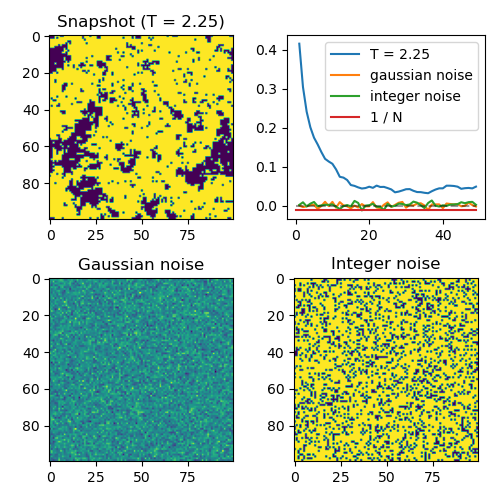

In [180]:
plt.close()
print(f"T = {temp[idx]:.2f} J = {normt[idx]:.2f} T_c")
fig, ((ax, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(5, 5))
im = ax.imshow(snapshots[idx])
ax.set_title(f"Snapshot (T = {temp[idx]:.2f})")

cor_x = np.arange(len(autocor))
ax2.plot(cor_x[1:], autocor[1:], label=f"T = {temp[idx]:.2f}")
#ax2.plot(cor_x[1:], extern_autocor, label="external")
ax2.plot(cor_x[1:], autocor_gaussian[1:], label="gaussian noise")
ax2.plot(cor_x[1:], autocor_integer[1:], label="integer noise")
ax2.plot(cor_x, cor_x * 0 - 1 / params.N, label="1 / N")
ax2.plot(cor_x, cor_x * 0, color="black", linestyle="dashed", alpha=0.4)
ax2.legend()

ax3.imshow(gaussian_noise)
ax3.set_title("Gaussian noise")
ax4.imshow(integer_noise)
ax4.set_title("Integer noise")

fig.tight_layout()

plt.savefig(f"{test_path}/plots/snapshots_autocorrelation_T{temp[idx]:.3f}.png")

print(f"{snapshots[idx].mean()} ± {snapshots[idx].std():.4f}")
print(f"Maximum deviation between two autocorrelation fn's = {max(autocor[1:] - extern_autocor)}")
#fig.colorbar(im)
print(autocor[0]**0.5)

# OLD CODE STARTS HERE

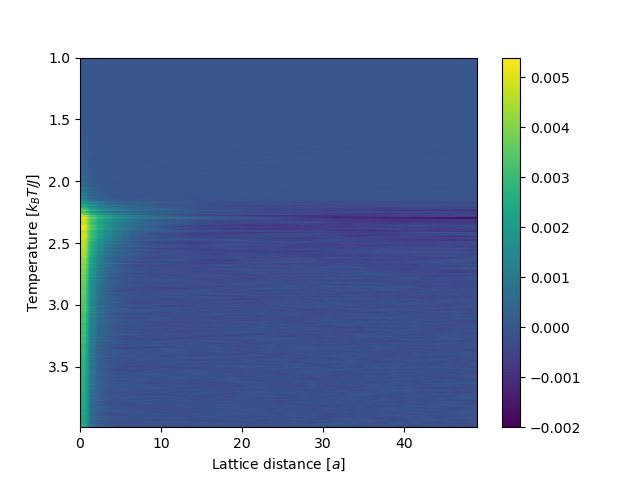

TypeError: Invalid shape (100, 49, 31) for image data

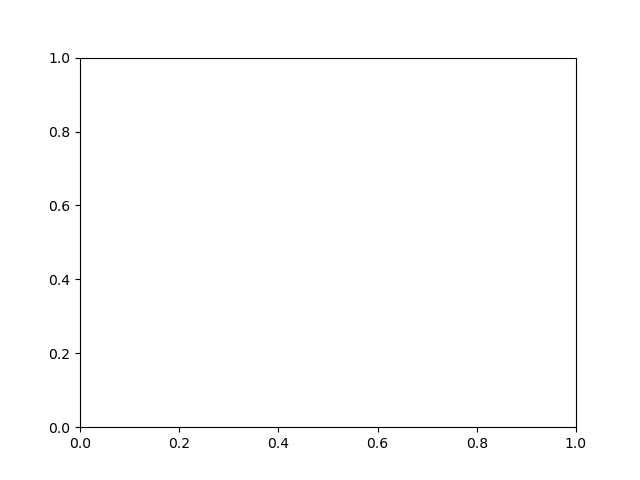

In [207]:
fig, ax = plt.subplots()
im = ax.imshow(sc_data, aspect="auto", extent=[0, sc_data.shape[1], temp[-1], temp[0]])
ax.set_ylabel("Temperature $[k_B T / J]$")
ax.set_xlabel("Lattice distance $[a]$")
fig.colorbar(im)

In [ ]:
decay = lambda x, A, xi : A * np.exp(- x / xi) if xi != 0 else A
A = np.empty_like(temp)
xi = np.empty_like(temp)
x = np.arange(sc_data.shape[1])

for i in np.arange(len(temp)):
    if np.abs(sc_data[i, :]).max() != 0:
        (val_A, val_xi), covm = curve_fit(decay, x, sc_data[i, :], p0=(sc_data[i, 0], 1e0))
    else:
        val_A, val_xi = 0, 0
    A[i] = val_A
    xi[i] = val_xi if np.abs(val_xi) < sc_data.shape[1] else 0
    

print(f"xi.shape = {xi.shape}, A.shape = {A.shape}")
print(f"xi.min = {xi.min()}, xi.max = {xi.max()}")

xi.shape = (300,), A.shape = (300,)
xi.min = 0.0, xi.max = 5.058530611585292


/var/folders/h6/326nqt2x2ql8ggvhjlhhckh40000gn/T/ipykernel_94980/3491209615.py:1: RuntimeWarning: overflow encountered in exp
  decay = lambda x, A, xi : A * np.exp(- x / xi) if xi != 0 else A
/Users/adrianhall/miniconda3/lib/python3.11/site-packages/scipy/optimize/_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


In [ ]:
winsize = 20
wincenter = winsize // 2
window = np.full(winsize, 1/winsize)
mav_xi = fftconvolve(xi, window, mode="same")
mvstd_xi = fftconvolve((xi - mav_xi)**2, window, mode="same")**0.5
mav_A = fftconvolve(A, window, mode="same")
mvstd_A = fftconvolve((A - mav_A)**2, window, mode="same")**0.5
mavdomain = slice(wincenter, -(wincenter - 1))
print(mav_xi.shape, mav_A.shape, mavdomain)

(300,) (300,) slice(10, -9, None)


Text(0, 0.5, 'Correlation length $\\xi$')

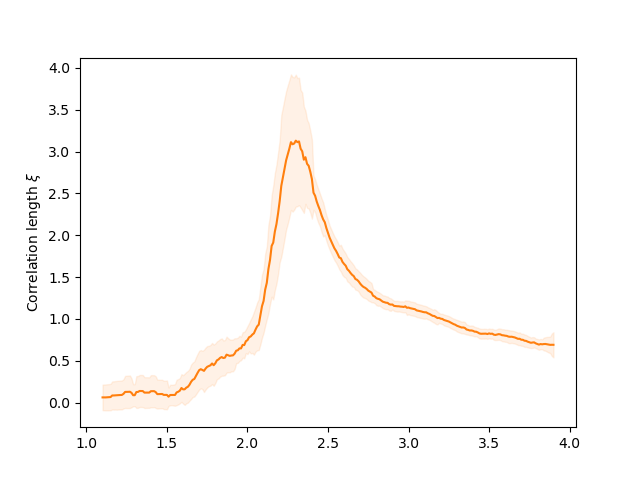

In [ ]:
fig, ax = plt.subplots()
#ax2 = ax.twinx()
# ax.plot(temp[mavdomain], mav_A[mavdomain], label="A", color="tab:blue")
# ax.fill_between(temp[mavdomain], mav_A[mavdomain] + mvstd_A[mavdomain], mav_A[mavdomain] - mvstd_A[mavdomain], color="tab:blue", alpha=0.1)
# ax.yaxis.label.set_color("tab:blue")
# ax2.spines["left"].set_edgecolor("tab:blue")
# ax.set_ylabel("A")
ax.plot(temp[mavdomain], mav_xi[mavdomain], label="xi", color="tab:orange")
ax.fill_between(temp[mavdomain], mav_xi[mavdomain] + mvstd_xi[mavdomain], mav_xi[mavdomain] - mvstd_xi[mavdomain], color="tab:orange", alpha=0.1)
ax.set_ylabel("Correlation length $\\xi$")

2.3000000000000003 3.384398532732046


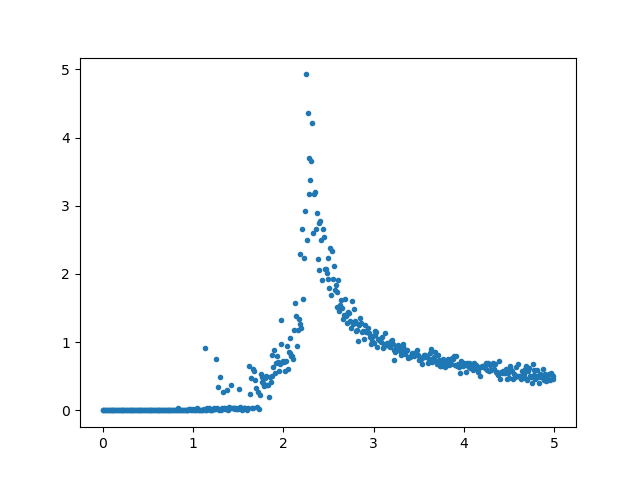

In [ ]:
plt.close()
fig, ax = plt.subplots()
ax.scatter(temp, xi, marker=".")
print(temp[230], xi[230])

Test: bsanity/sanity. T = 2.26J, Fit = 2.72e-03exp(- x / 2.50)


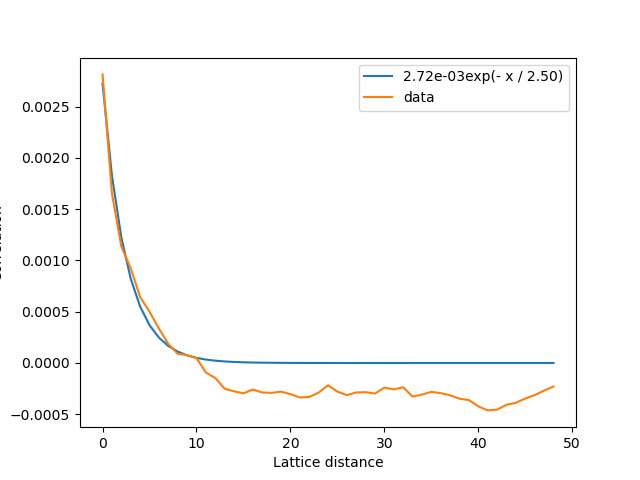

In [ ]:
plt.close()
fig, ax = plt.subplots()
idx = temp.searchsorted(2.26)
#print(A[i], xi[i])
ax.plot(x, decay(x, A[idx], xi[idx]), label=f"{A[idx]:.2e}exp(- x / {xi[idx]:.2f})")
ax.plot(x, sc_data[idx], label="data")
ax.set_xlabel("Lattice distance")
ax.set_ylabel("Correlation")
# ax.plot(temp[tstart:tend], A, label="A")
# ax.plot(temp[tstart:tend], xi, label="xi")
ax.legend()
print(f"Test: {test_name}. T = {temp[idx]:.2f}J, Fit = {A[idx]:.2e}exp(- x / {xi[idx]:.2f})")

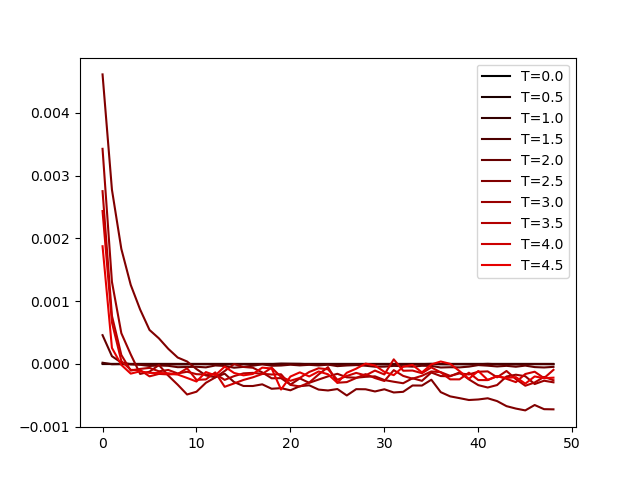

In [ ]:


fig, ax = plt.subplots()
for i in np.arange(tstart, tend, (tend - tstart) // 10):
    ax.plot(sc_data[i, :], label=f"T={temp[i]}", color=(temp[i]/5, 0, 0))
    
ax.legend()